In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm 

import time

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 07: Redução de dimensionalidade

**1.** Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados
referem-se a medições anatômicas de pinguins da Antártida, classificados nas
espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem
ser conferidos em https://allisonhorst.github.io/palmerpenguins/.

**a)** Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

**b)** Ainda considerando o item anterior, calcule e mostre a variância explicada obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

Normalize os dados antes de executar PCA. Implemente sua própria versão de PCA, mas verifique a corretude comparando contra alguma implementação popular (e.g., da biblioteca scikitlearn).

In [71]:
#dividir o dataset "penguins.csv" em features e labels
data = pd.read_csv('penguins.csv', header=None)
data_labels = data[4]
data_features = data.drop(columns=[4])

Vamos normalizar os dados e criar uma amtriz de covariâncias.

In [72]:
#normalizando os dados
data_features = (data_features - data_features.mean()) / data_features.std()

#obtendo matriz de cov
cov_matrix = data_features.cov()

Precisamos calcular os autovalores e autovetores da matriz de covariâncias, ordená-los e selecionar os $k$ maiores autovalores e seus respectivos autovetores.

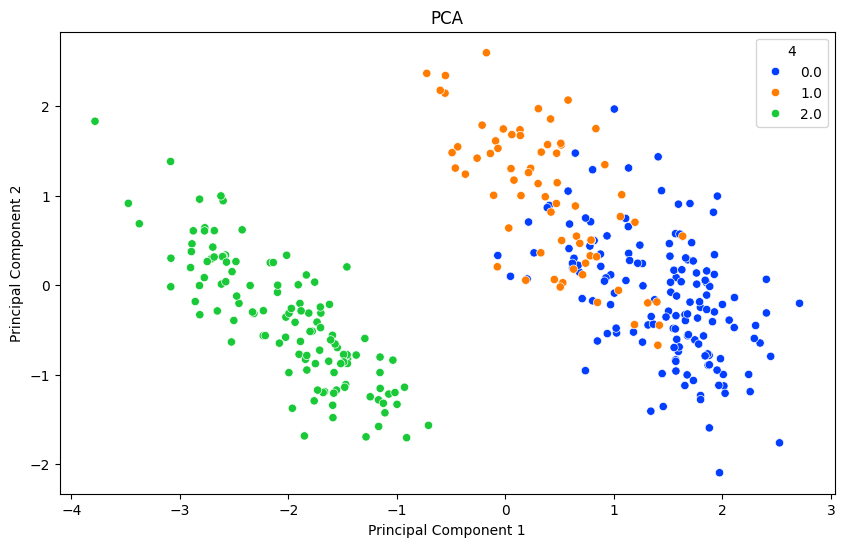

In [74]:
#autovalores e autolevetores de cov
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

#ordenando os autovalores e autovetores
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

#selecionando autovetores correspondentes aos autovalores selecionados
matrix = eigenvectors[:,:2]

#projetando os dados no novo espaço
data_projected = data_features.dot(matrix)

#concatenando features e labels
data = pd.concat([data_projected, data_labels], axis=1)
data[4] = data[4].astype('category')

#plotando os dados
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x=0, y=1, hue=4,  palette='bright')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.show()

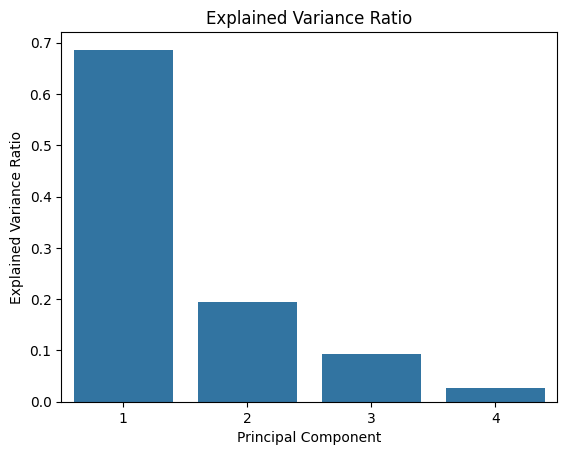

In [75]:
#get explained variance ratio
explained_variance_ratio = eigenvalues / eigenvalues.sum()

#plot explained variance ratio where principal component is categorical
sns.barplot(x=[1,2,3,4], y=explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio')
plt.show()


Agora, vamos comparar os resultados obtidos com a implementação do scikit-learn.


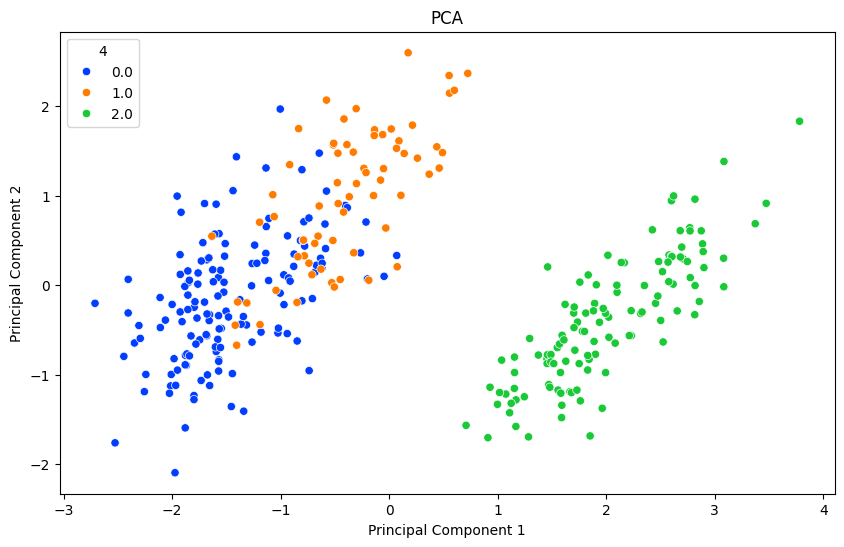

In [76]:
#use PCA from sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_projected = pca.fit_transform(data_features)

#concatenate the projected data with the labels
data_projected = pd.concat([pd.DataFrame(data_projected), data_labels], axis=1)
data_projected[4] = data_projected[4].astype('category')

#plot data using data_projected[4] as color legend
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_projected, x=0, y=1, hue=4,  palette='bright')
# add labels to the plot
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.show()


Note que tivemos uma projeção similar a implementada anteriormente. A diferença é que as duas estão espelhadas, mas a distribuição das distâncias dos pontos permanecem as mesmas entre si. 

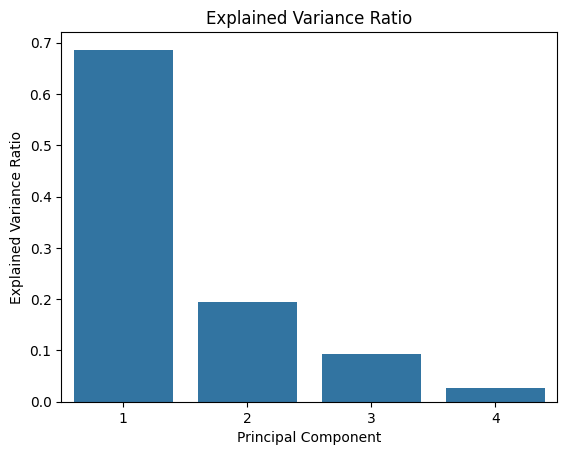

In [77]:
#get explained variance ratio for all
pca = PCA(n_components=4)
data_projected = pca.fit_transform(data_features)

explained_variance_ratio = pca.explained_variance_ratio_

#plot
sns.barplot(x=[1,2,3,4], y=explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio')
plt.show()


**2.** Implemente um autoencoder determinísitco para o banco de dados MNIST, que já usamos em exercícios anteriores. Você pode escolher utilizar tanto CNN como MLP no encoder/decoder. No entanto, o encoder deve mapear as imagens no $\mathbb{R}^2$, para podermos visualizar as representações latentes no plano. Use o conjunto de validação para fazer early stopping. Você também pode monitorar o erro na validação para anelar a taxa de aprendizado (usando um scheduler). Finalmente, mostre a projeção das imagens de teste no espaço latente e comente qualitativamente os embeddings obtidos.

In [78]:
train_val_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

Failed to download (trying next):
<urlopen error [WinError 10060] Uma tentativa de conexão falhou porque o componente conectado não respondeu
corretamente após um período de tempo ou a conexão estabelecida falhou
porque o host conectado não respondeu>



100%|██████████| 9912422/9912422 [00:01<00:00, 6590649.93it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 198179.60it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 1830970.74it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10060] Uma tentativa de conexão falhou porque o componente conectado não respondeu
corretamente após um período de tempo ou a conexão estabelecida falhou
porque o host conectado não respondeu>



100%|██████████| 4542/4542 [00:00<00:00, 2237816.14it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



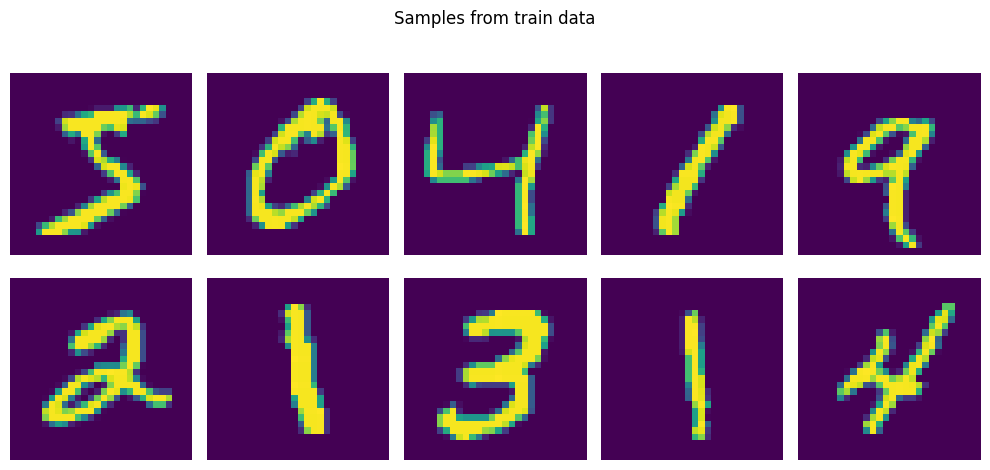

In [79]:
fig, ax = plt.subplots(2,5, figsize=(10,5))

for i in range(10):
    ax[i//5,i%5].imshow(train_val_dataset.data[i])
    ax[i//5,i%5].axis('off')
    
fig.suptitle("Samples from train data")
fig.tight_layout()

In [80]:
# encoder com um MLP for MNIST
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
# decoder com um MLP for MNIST
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 28*28)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [81]:
loss = nn.MSELoss()
lr = 0.001
encoder = Encoder()
decoder = Decoder()

#optimizer
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

#train the model
n_epochs = 10
batch_size = 128
for epoch in range(n_epochs):
    for batch in train_val_dataset:
        optimizer.zero_grad()
        x, _ = batch
        x_hat = decoder(encoder(x))
        l = loss(x_hat, x.view(-1, 28*28))
        l.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss {l.item()}")

Epoch 1, Loss 0.04250103235244751
Epoch 2, Loss 0.04576271027326584
Epoch 3, Loss 0.04138696938753128
Epoch 4, Loss 0.04307926818728447
Epoch 5, Loss 0.04583754017949104
Epoch 6, Loss 0.03846214339137077
Epoch 7, Loss 0.038777824491262436
Epoch 8, Loss 0.04057701304554939
Epoch 9, Loss 0.03771186247467995
Epoch 10, Loss 0.0374024473130703


Vamos verificar como o espaço latente está se comportando.


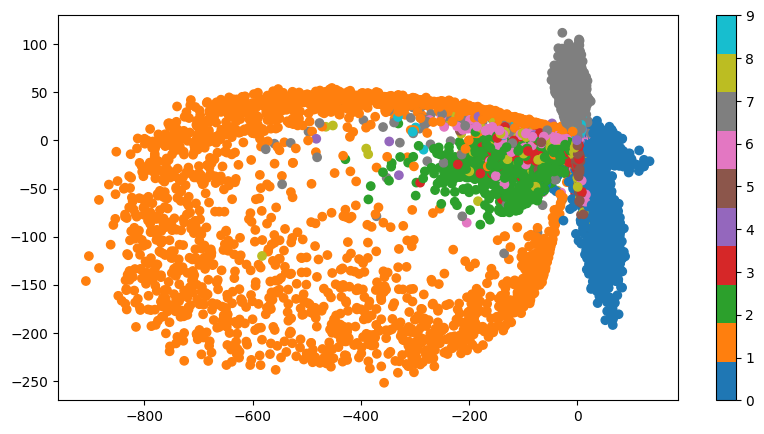

In [91]:
# get latent space for val_data
def plot_latent(data):
    for i, (x, y) in enumerate(data):
        encoded = encoder(x)
        plt.scatter(encoded.detach()[:, 0], encoded.detach()[:, 1], c=y, cmap='tab10')
        if i > 100:
            plt.colorbar()
            break

fig = plt.figure(figsize=(10, 5))
plot_latent(DataLoader(train_val_dataset, batch_size=256, shuffle=True))


Podemos observar que as imagens de mesmo label foram (numa forma geral) agrupadas num mesmo espaço. Isso é um indicativo de que o autoencoder conseguiu aprender uma representação latente que preserva a informação de classe.

In [96]:
# use validation for early stopping
def validacao(dataset):
    loss_total = 0
    for x, _ in dataset:
        x_hat = decoder(encoder(x))
        l = loss(x_hat, x.view(-1, 28*28))
        loss_total += l.item()
    return loss_total/len(dataset)

#train the data with early validation
n_epochs = 100
batch_size = 128
best_loss = 1000
for epoch in range(n_epochs):
    for batch in train_val_dataset:
        optimizer.zero_grad()
        x, _ = batch
        x_hat = decoder(encoder(x))
        l = loss(x_hat, x.view(-1, 28*28))
        l.backward()
        optimizer.step()
    val_loss = validacao(test_dataset)
    if val_loss < best_loss:
        best_loss = val_loss
    else:
        print(f"Early stopping at epoch {epoch+1}")
        break
    print(f"Epoch {epoch+1}, Loss {l.item()}, Validation Loss {val_loss}")



Epoch 1, Loss 0.043158262968063354, Validation Loss 0.04218341774730943
Early stopping at epoch 2


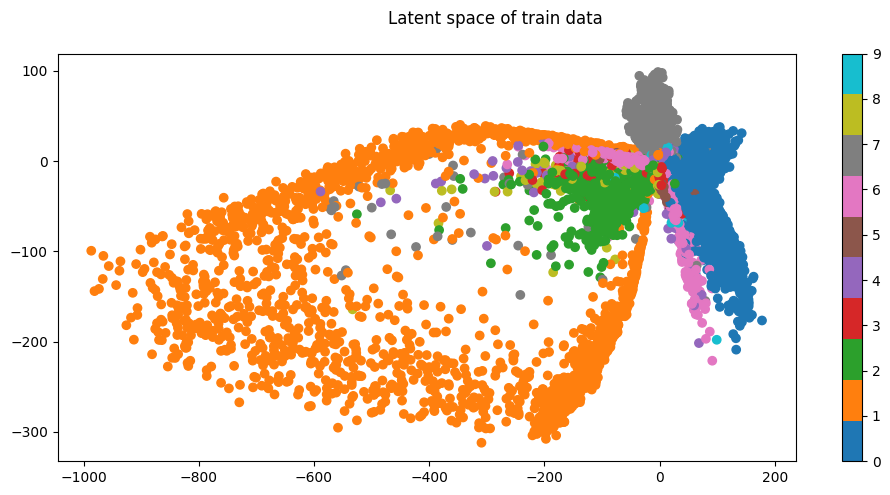

In [99]:

fig = plt.figure(figsize=(10,5))
plot_latent(DataLoader(train_val_dataset, batch_size=256, shuffle=True))
fig.suptitle("Latent space of train data")
fig.tight_layout()




Por fim, é relevante que as imagens com mesmo label estão próximas umas das outras, indicando que o autoencoder conseguiu aprender uma representação latente que preserva a informação de classe. O embedding obtido é qualitativamente bom e o modelo parece ter aprendido a um nível satisfatório.